## Classificadores multiclasses e Modelos de Linguagem

**OBJETIVO:** Ao final desta aula, você será capaz de interpretar e discutir embeddings de acordo com sua formulação matemática.

Até agora, trabalhamos com classificadores binários, que distinguem apenas duas classes. Entretanto, muitos problemas de classificação envolvem mais de duas categorias — são **multiclasse**, ou seja, o modelo precisa escolher entre várias classes possíveis. Por exemplo, o conjunto de dados `20newsgroups` contém 20 categorias diferentes, e nosso objetivo é classificar corretamente cada documento em uma dessas 20 classes.

> **Explicação aprofundada:**  
> - **Classificação binária vs. multiclasses:**  
>   - *Binária:* apenas duas opções (ex.: spam × não-spam).  
>   - *Multiclasse:* _K_ opções (neste caso, 20 tópicos).  
> - **Por que resolver problemas multiclasses?**  
>   - São comuns em tarefas de NLP, como categorização de notícias, análise de sentimentos com múltiplas emoções ou detecção de intenções em sistemas de diálogo.  
> - **Dataset 20newsgroups:**  
>   - Contém cerca de 18.000 documentos distribuídos em 20 fóruns de discussão (ex.: ciência, esportes, religião).  
>   - É amplamente usado para avaliar algoritmos de texto devido à sua variedade de tópicos.

**Próximos passos desta aula:**

1. Carregar e explorar o dataset `20newsgroups`.  
2. Pré-processar os textos (tokenização e vetorização).  
3. Implementar e treinar um classificador multiclasse (por exemplo, regressão logística).  
4. Avaliar o desempenho utilizando métricas como precisão, recall e F1 para cada classe.  
5. Entender embeddings de palavras e documentos, analisando sua formulação matemática.

### Carregando o dataset 20newsgroups

Neste trecho, vamos importar o conjunto de dados `20newsgroups` do scikit-learn e armazenar os textos em `X` e os rótulos em `y`. Em seguida, exibiremos as cinco primeiras amostras de `X` e `y` para entender o formato dos dados e verificar a quantidade de classes presentes.

> **Explicações adicionais para iniciantes:**
> - `fetch_20newsgroups(subset='train')`: carrega apenas o conjunto de treino (~11.300 documentos distribuídos em 20 categorias).
> - `newsgroups_train.data`: lista de strings, cada uma contendo o texto de um documento.
> - `newsgroups_train.target`: lista de inteiros, cada inteiro corresponde à posição da categoria do documento.
> - `len(set(y))`: conta quantas classes distintas existem — deve resultar em 20.

In [2]:
from sklearn.datasets import fetch_20newsgroups

# Carrega o conjunto de treino do 20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

# Armazena os textos em X e os rótulos em y
X = newsgroups_train.data
y = newsgroups_train.target

# Exibe as 5 primeiras amostras de texto
print("Primeiros 5 textos:\n", X[0:5])

# Exibe os 5 primeiros rótulos
print("Primeiros 5 rótulos:\n", y[0:5])

# Exibe o número de classes distintas
print("Número de classes distintas:", len(set(y)))

Primeiros 5 textos:
 ["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n", "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of

## Regressão Logística Multiclasse

Embora o **scikit‑learn** trate automaticamente a classificação multiclasse, no **PyTorch** precisamos prestar atenção em três pontos principais:

1. **Número de saídas da camada de classificação**: deve ser igual ao número de classes (_c_) do problema.  
2. **Função de ativação**: em vez de usar a sigmoide (adequada para binária), usaremos a **Softmax**, que normaliza múltiplos valores.  
3. **Função de perda**: em vez de Binary Cross Entropy (BCE), utilizamos a **Cross Entropy Loss**, que computa a entropia cruzada entre a distribuição prevista e a verdadeira.

---

### Como isso funciona na prática?

1. **Saídas múltiplas**  
   - No classificador binário, calculávamos o logit pela equação:  
     $$
     \boldsymbol{z} = \boldsymbol{x}\,\boldsymbol{w}^T + b,
     $$  
     em que $\boldsymbol{x}\in\mathbb{R}^{1\times d}$ e $\boldsymbol{w}\in\mathbb{R}^{d\times 1}$, resultando em $\boldsymbol{z}\in\mathbb{R}^{1\times 1}$.  

   - Para duas classes, estendemos $\boldsymbol{w}$ para ter duas colunas:  
     $$
     \boldsymbol{z} 
     = \boldsymbol{x}\,\boldsymbol{W} + \boldsymbol{b}
     = 
     \begin{bmatrix} x_1 & x_2 & \cdots & x_d \end{bmatrix}
     \begin{bmatrix}
       w_{1,1} & w_{1,2} \\
       w_{2,1} & w_{2,2} \\
       \vdots  & \vdots  \\
       w_{d,1} & w_{d,2}
     \end{bmatrix}
     +
     \begin{bmatrix} b_1 & b_2 \end{bmatrix},
     $$  
     gerando $\boldsymbol{z}\in\mathbb{R}^{1\times 2}$.  

   - De modo geral, para $c$ classes:  
     $$
     \boldsymbol{z}
     = \boldsymbol{x}\,\boldsymbol{W} + \boldsymbol{b},
     $$  
     com $\boldsymbol{W}\in\mathbb{R}^{d\times c}$ e $\boldsymbol{b}\in\mathbb{R}^{1\times c}$,  
     resultando em $\boldsymbol{z}\in\mathbb{R}^{1\times c}$.  

2. **Softmax**  
   - Transformamos os logits $\boldsymbol{z_i}$ em probabilidades $\boldsymbol{y_i}$ pela **Softmax**:  
     $$
     y_i \;=\; \frac{e^{z_i}}{\sum_{j=1}^{c} e^{z_j}}\,. 
     $$

   - **Por que a exponencial?**  
     A função exponencial amplifica diferenças entre os logits:  
     - Logits maiores viram probabilidades muito maiores,  
     - Logits menores viram probabilidades quase nulas.  
     
     Isso faz com que, quando o modelo está mais confiante, a distribuição resultante tenha **baixa entropia**, concentrando a massa de probabilidade na(s) classe(s) mais provável(is).


3. **Cross Entropy Loss**  
   - Para comparar a distribuição prevista $\boldsymbol{y}$ com a verdadeira (one‑hot vector), usamos:  
     $$
     \mathcal{L} \;=\; -\sum_{i=1}^{c} t_i \,\log y_i,
     $$
     em que  
     - $\boldsymbol{t_i = 1}$ para a classe correta,  
     - $\boldsymbol{t_i = 0}$ para todas as demais,  
     - $\boldsymbol{y_i}$ é a probabilidade prevista pela Softmax.  
   - **Interpretação aprofundada:**  
     - Formamos um vetor one‑hot $\boldsymbol{t}$ de tamanho $\boldsymbol{c}$.  
     - A entropia cruzada mede a discrepância entre a distribuição “verdadeira” $\boldsymbol{t}$ e a prevista $\boldsymbol{y}$.  
     - Como apenas o termo com $\boldsymbol{t_i = 1}$ contribui para a soma, a fórmula simplifica para  

$$
\mathcal{L} = -\log\bigl(y_{\text{classe correta}}\bigr)
$$

- Minimizar $\displaystyle \mathcal{L}$ equivale a maximizar $y_{\text{classe correta}}$.

   - **Em PyTorch:** use  
     ```python
     criterion = nn.CrossEntropyLoss()
     loss = criterion(logits, labels)
     ```  
     que internamente combina `log_softmax` e `nll_loss` de forma estável.

---

## Exercício: Avaliar um modelo pré‑treinado

Modelos de classificação multiclasse geralmente têm muitos parâmetros, o que torna o treinamento desafiador. Para simplificar, neste exercício:

1. **Defina o objeto de modelo** exatamente como foi treinado (mesma arquitetura).  
2. **Carregue os pesos** a partir de um **state dictionary** (.pth ou .pt).

> **Importante:**  
> O PyTorch **não** recomenda salvar objetos via `joblib` ou `pickle` diretamente, pois isso pode executar código malicioso ao carregar.  
> Utilize sempre:
> ```python
> model = MyModel(...)
> model.load_state_dict(torch.load('model_weights.pth'))
> model.eval()
> ```

### Tokenização com SentencePiece e Função de Padding

Para trabalhar com modelos de linguagem, primeiro precisamos converter texto em sequências numéricas (IDs de tokens) e garantir que todas as sequências tenham o mesmo tamanho:

1. **SentencePiece**: biblioteca que implementa tokenização subword.  
   - `SentencePieceProcessor()`: objeto que gerencia o vocabulário e as regras de tokenização.  
   - `sp.load('fakenews_tokenizer.model')`: carrega o modelo treinado.  
   - `sp.piece_to_id('<PAD>')`: obtém o ID reservado para o token `<PAD>`, usado para preencher (padding).

2. **Função `pad_to_len`**:  
   - Recebe:
     - `sequences`: lista de listas de IDs de tokens.  
     - `pad_idx`: ID do token de padding.  
     - `max_len`: tamanho desejado para todas as sequências.  
   - Para cada sequência `s`:
     - Se `len(s) >= max_len`, truncamos para `max_len`.  
     - Caso contrário, estendemos com o token de padding até atingir `max_len`.  
   - Retorna uma nova lista com as sequências ajustadas.

> **Por que isso é importante?**  
> Em frameworks como PyTorch, para processar lotes (_batches_), todos os tensores de entrada devem ter o **mesmo** formato. O padding garante tamanhos uniformes sem distorcer o significado dos tokens originais.

In [3]:
import sentencepiece as spm

# Inicializa o tokenizador SentencePiece
sp = spm.SentencePieceProcessor()
sp.load('fakenews_tokenizer.model')

# Índice reservado para o token de padding
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    """
    Ajusta todas as sequências para o mesmo comprimento (max_len):
      - Trunca se a sequência for maior ou igual a max_len.
      - Adiciona tokens de padding (pad_idx) se for menor.
    """
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            # Trunca a sequência
            padded.append(s[:max_len])
        else:
            # Adiciona tokens de padding ao final
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

### Definição do Classificador Multiclasse em PyTorch

A seguir, definimos nossa classe de rede neural para classificação multiclasse:

1. **Imports essenciais**  
   - `pandas`, `Path`, `tqdm`: úteis para manipulação de dados, caminhos de arquivo e exibição de progresso.  
   - `torch`, `torch.nn`, `torch.nn.functional`: componentes do PyTorch para criação de tensores e camadas de rede.

2. **Camada de Embedding**  
   - `nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=padding_idx)`  
   - Converte IDs de tokens em vetores densos de dimensão `embedding_dim`.  
   - O parâmetro `padding_idx` garante que o vetor correspondente ao token de padding seja sempre zero (não afeta a média).

3. **Camada de Classificação**  
   - `nn.Linear(embedding_dim, n_classes)`  
   - Recebe o vetor resumido de dimensão `embedding_dim` e gera `n_classes` saídas (logits).

4. **Função de sumarização**  
   - `summarize(x)` faz a média dos embeddings ao longo da dimensão de sequência (`dim=1`), produzindo um único vetor por exemplo.  
   - **Por que usar média?** Uma estratégia simples para agregar informações de toda a sequência sem camadas recorrentes ou transformadores.

5. **Forward pass**  
   - Passo 1: converte IDs em embeddings.  
   - Passo 2: agrega embeddings em um vetor fixo.  
   - Passo 3: aplica a camada linear para obter os logits de cada classe.  

> **Observação para iniciantes:**  
> - Os **logits** resultantes ainda não são probabilidades; devem ser passados por **Softmax** antes de interpretar como distribuição.  
> - Na hora de calcular a perda, use `nn.CrossEntropyLoss()`, que aplica internamente `log_softmax` + `nll_loss`.

In [4]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

class MulticlassClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_classes, padding_idx):
        super().__init__()
        # Embedding converte IDs de tokens em vetores densos
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        # Camada linear para gerar logits de cada classe
        self.clf = nn.Linear(embedding_dim, n_classes)

    def summarize(self, x):
        """
        Agrega a sequência de embeddings em um único vetor,
        calculando a média ao longo da dimensão de sequência.
        """
        return x.mean(dim=1)

    def forward(self, x):
        # x: tensor de shape [batch_size, seq_len] com IDs de tokens
        x = self.embedding(x)      # → [batch_size, seq_len, embedding_dim]
        x = self.summarize(x)      # → [batch_size, embedding_dim]
        logits = self.clf(x)       # → [batch_size, n_classes]
        return logits

### Preparação dos Dados de Teste

Nesta etapa, vamos:

1. **Carregar o conjunto de teste** do `20newsgroups`.  
2. **Filtrar** apenas as classes permitidas (`0–19`).  
3. **Tokenizar** cada documento usando o SentencePiece.  
4. **Aplicar padding** para que todas as sequências tenham comprimento fixo (500 tokens).  
5. **Converter** para tensores PyTorch.

> **Explicações detalhadas:**  
> - `subset='test'` carrega apenas os ~7.500 documentos de teste.  
> - `allowed_classes = set(range(20))` garante que consideramos exatamente as 20 categorias.  
> - `class_indices`: lista de índices dos documentos cujos rótulos estão em `allowed_classes` (todas, nesse caso).  
> - `sp.encode_as_ids([...])` transforma cada texto em uma lista de IDs de tokens.  
> - `pad_to_len(..., max_len=500)`:  
>   - Se a lista tiver mais de 500 tokens, truncamos.  
>   - Se tiver menos, preenchermos com `padding_idx` até 500.  
> - `torch.tensor(...)` converte a lista de sequências e rótulos em tensores, prontos para alimentar o modelo.

In [5]:
from sklearn.datasets import fetch_20newsgroups

# 1. Carrega o conjunto de teste
newsgroups_test = fetch_20newsgroups(subset='test')
X_test = newsgroups_test.data
y_test = newsgroups_test.target

# 2. Definimos as classes permitidas (0 a 19) e filtramos
allowed_classes = set(range(20))
class_indices = [i for i, label in enumerate(y_test) if label in allowed_classes]

# 3. Tokenizamos apenas os documentos filtrados
sequences = [X_test[i] for i in class_indices]
tokens = sp.encode_as_ids(sequences)

# 4. Aplicamos padding/truncation para comprimento 500
tokens = pad_to_len(tokens, padding_idx, max_len=500)

# 5. Convertendo para tensores PyTorch
tokens = torch.tensor(tokens)                # shape: [n_samples, 500]
labels = torch.tensor(y_test[class_indices]) # shape: [n_samples]

print("Tokens tensor shape:", tokens.shape)
print("Labels tensor shape:", labels.shape)

Tokens tensor shape: torch.Size([7532, 500])
Labels tensor shape: torch.Size([7532])


### Carregando o Modelo Pré‑treinado e Entrando em Modo Avaliação

Neste trecho, vamos:

1. **Instanciar** nosso classificador multiclasse com a mesma arquitetura usada no treinamento:
   - `vocab_size=5000`: tamanho do vocabulário (número de tokens distintos).  
   - `embedding_dim=60`: dimensão dos vetores de embedding.  
   - `n_classes=20`: número de classes do problema (20 tópicos do 20newsgroups).

2. **Carregar os pesos** pré‑treinados:
   - `model.load_state_dict(...)` injeta os pesos salvos em `'newsgroups_mean.pth'` no nosso modelo, garantindo que a arquitetura corresponda exatamente à do treinamento.  
   - O parâmetro `weights_only=True` (quando suportado) certifica que só os tensores de pesos são carregados, sem metadados extras.

3. **Colocar o modelo em modo avaliação**:
   - `model.eval()` desativa comportamentos como Dropout e BatchNorm em modo de treinamento, deixando-o pronto para fazer previsões determinísticas.

> **Dica para iniciantes:**  
> - Sempre garanta que a arquitetura do modelo (camadas, dimensões) corresponda àquela usada para gerar o arquivo de pesos.  
> - Chamar `eval()` é crucial antes de inferir, para não ter variações nas saídas por camadas que se comportam diferente em treino vs. inferência.

In [7]:
# 1. Instancia o classificador com os mesmos parâmetros usados no treinamento
model = MulticlassClassifier(
    vocab_size=5000,
    embedding_dim=60,
    n_classes=20,
    padding_idx=padding_idx
)

# 2. Carrega os pesos pré‑treinados
state_dict = torch.load('newsgroups_mean.pth', weights_only=True)
model.load_state_dict(state_dict)

# 3. Muda o modelo para modo avaliação (desativa Dropout, BatchNorm etc.)
model.eval()

MulticlassClassifier(
  (embedding): Embedding(5000, 60, padding_idx=3)
  (clf): Linear(in_features=60, out_features=20, bias=True)
)

### Avaliação de Desempenho com Acurácia

Neste trecho, vamos calcular a **acurácia** do modelo, que é a proporção de previsões corretas sobre o total de exemplos:

1. **Obter as probabilidades (logits)**  
   ```python
   y_pred_probs = model(tokens)

O modelo retorna um tensor de forma [n_samples, n_classes] com os logits (pontuações antes da Softmax).


In [9]:
from sklearn.metrics import accuracy_score

# 1. Executa o modelo para obter logits
y_pred_probs = model(tokens)              # tensor [n_samples, n_classes]

# 2. Seleciona a classe mais provável (argmax)
y_pred = torch.argmax(y_pred_probs, axis=1)

# 3. Prepara previsões e rótulos para o sklearn
y_pred = y_pred.detach().cpu().numpy()    # previsões como NumPy array

# Supondo que você tenha salvo os rótulos em 'labels' como tensor:
# labels = torch.tensor(y_test[class_indices])
y_true = labels.numpy()                   # rótulos verdadeiros como NumPy array

# 4. Calcula a acurácia
accuracy = accuracy_score(y_true, y_pred)

# 5. Exibe o resultado
print(f"Acurácia: {accuracy:.4f}")

Acurácia: 0.7066


### Visualização das Projeções dos Embeddings

Aqui vamos gerar duas figuras separadas (sem subplots) mostrando a projeção dos embeddings médios:

1. Selecionar 1.000 amostras aleatórias.  
2. Extrair embeddings médios pelo método `summarize`.  
3. Projetar em 2D usando **PCA** e **t-SNE**.  
4. Plotar cada projeção em uma figura distinta para melhor legibilidade.

> **Observação:**  
> - Cada gráfico é criado em sua própria janela (sem subplots).  
> - O parâmetro `c=y_sample` colore automaticamente os pontos de acordo com a classe, sem especificar manualmente uma paleta.

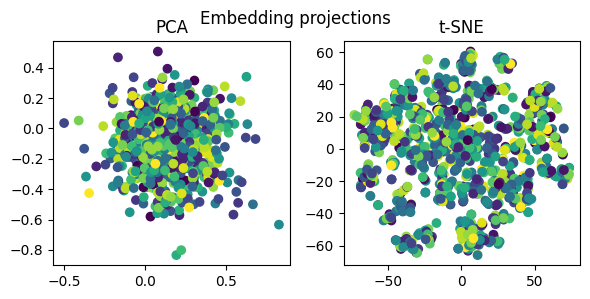

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

indices = torch.randperm(tokens.size(0))[:1000]
tokens_sample = tokens[indices]
y_sample = y[indices]
embeddings_post = model.summarize(model.embedding(tokens_sample)).detach().cpu().numpy()

pca = PCA(n_components=2)
embeddings_post_pca = pca.fit_transform(embeddings_post)
tsne = TSNE(n_components=2, perplexity=5)
embeddings_post_tsne = tsne.fit_transform(embeddings_post)
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.scatter(embeddings_post[:,0], embeddings_post[:,1], c=y_sample)
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(embeddings_post_tsne[:,0], embeddings_post_tsne[:,1], c=y_sample)
plt.title("t-SNE")
plt.tight_layout()
plt.suptitle("Embedding projections")
plt.show()

## Lidando com grandes conjuntos de dados

Alguns conjuntos de dados são grandes demais para caberem de uma vez na memória RAM ou na memória da GPU. Para contornar isso, dividimos o dataset em **minibatches** — pequenos lotes de dados (tipicamente entre 16 e 128 exemplos, mas o tamanho ideal varia conforme o problema). Cada minibatch é carregado, processado e usado para fazer um passo de otimização antes de liberar a memória e carregar o próximo.

O PyTorch oferece duas abstrações-chave para isso:

1. **`Dataset`**  
   - Responsável por **recuperar um único exemplo** (normalmente um par `(entrada, rótulo)`) a partir do índice que você informar.  
   - Deve implementar dois métodos essenciais:
     ```python
     def __len__(self):
         # retorna o número total de exemplos
     def __getitem__(self, idx):
         # retorna (entrada, rótulo) para o índice idx
     ```

2. **`DataLoader`**  
   - Recebe um `Dataset` e agrupa os exemplos em minibatches.  
   - Principais parâmetros:
     - `batch_size`: número de exemplos por minibatch.  
     - `shuffle`: embaralha os índices a cada época, evitando vieses de ordenação.  
     - `num_workers`: quantos subprocessos usar para carregar dados em paralelo.  

> **Vantagens dos minibatches**  
> - **Memória**: apenas parte dos dados está na RAM/GPU de cada vez.  
> - **Estabilidade**: processamento de poucos exemplos por iteração suaviza o bucle de otimização.  
> - **Paralelismo**: múltiplos workers permitem carregar dados enquanto a GPU treina no lote anterior.

### Exemplo de uso

```python
import torch
from torch.utils.data import Dataset, DataLoader

# 1) Defina seu Dataset
class MyTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # converte texto em IDs e aplica padding
        token_ids = self.tokenizer.encode_as_ids(text)
        if len(token_ids) < self.max_len:
            token_ids += [self.tokenizer.piece_to_id('<PAD>')] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]
        return torch.tensor(token_ids), torch.tensor(label)

# 2) Crie uma instância de Dataset
dataset = MyTextDataset(
    texts=X_train,             # lista de strings
    labels=y_train,            # lista/array de inteiros
    tokenizer=sp,              # SentencePieceProcessor já carregado
    max_len=500
)

# 3) Empacote em um DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

# 4) Loop de treinamento com minibatches
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    for batch_tokens, batch_labels in dataloader:
        # batch_tokens: [32, 500], batch_labels: [32]
        optimizer.zero_grad()
        logits = model(batch_tokens)            # → [32, n_classes]
        loss = criterion(logits, batch_labels)  # calcula Cross Entropy
        loss.backward()
        optimizer.step()
    print(f"Época {epoch+1}/{num_epochs} concluída, perda = {loss.item():.4f}")

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data # If data does not fit memory, change this to e.g. indexes or file pointers
        self.labels = labels

    def __len__(self): # Returns the number of items in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx], self.labels[idx]
        return sample

# Create some sample data
data = torch.randn(100, 2)  # 100 samples, each with 2 features
labels = torch.randint(0, 2, (100,1))  # 100 labels (binary classification)

# Create the dataset
dataset = MyDataset(data, labels)
print(dataset[1]) # This actually calls __getitem__

(tensor([1.3746, 0.6599]), tensor([0]))


In [21]:
# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
)

# Iterate through the DataLoader
for x, y in dataloader:
    print(x)
    print(y)
    break  # Print only the first batch for demonstration

tensor([[ 0.9268,  0.0931],
        [-0.5104, -0.7227],
        [ 1.0721, -0.5083],
        [-1.2362,  0.8824]])
tensor([[1],
        [0],
        [1],
        [1]])


## Exercício: usar pesos pré‑treinados de uma RNN

No script `train_newsgroups_rnn_minibatch.py` encontramos:

1. **Model definition**  
   ```python
   class MulticlassClassifierRNN(nn.Module):
       def __init__(self, vocab_size, embedding_dim, n_classes):
           super().__init__()
           self.embedding = nn.Embedding(
               num_embeddings=vocab_size,
               embedding_dim=embedding_dim,
               padding_idx=padding_idx
           )
           self.rnnlayer = nn.RNN(
               input_size=embedding_dim,
               hidden_size=embedding_dim,
               num_layers=1,
               batch_first=True
           )
           self.clf = nn.Linear(embedding_dim, n_classes)

       def summarize(self, x):
           x, _ = self.rnnlayer(x)
           return x.mean(dim=1)

       def forward(self, x):
           x = self.embedding(x)
           x = self.summarize(x)
           return self.clf(x)

Acurácia RNN: 0.5441


/Users/luizfelipelazzaron/Documents/2025/nlp/nlp_course-1/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


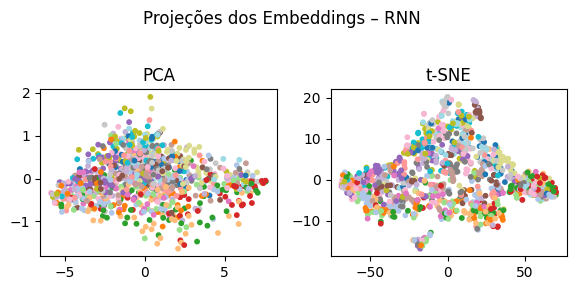

In [26]:
import torch
import torch.nn as nn
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sentencepiece as spm

# 1) Tokenizador e função de padding
sp = spm.SentencePieceProcessor()
sp.load('fakenews_tokenizer.model')
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

# 2) Carregar e preparar dados de teste
ng_test = fetch_20newsgroups(subset='test')
X_test, y_test = ng_test.data, ng_test.target
indices = [i for i, lbl in enumerate(y_test) if lbl < 20]
seqs = [X_test[i] for i in indices]
tokens = sp.encode_as_ids(seqs)
tokens = pad_to_len(tokens, padding_idx, max_len=500)
tokens = torch.tensor(tokens)
labels = torch.tensor([y_test[i] for i in indices])

# 3) Definição da RNN (mesma do treino)
class MulticlassClassifierRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_classes, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnnlayer = nn.RNN(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.clf = nn.Linear(embedding_dim, n_classes)

    def summarize(self, x):
        x, _ = self.rnnlayer(x)
        return x.mean(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.summarize(x)
        return self.clf(x)

# 4) Instanciar e carregar pesos
model = MulticlassClassifierRNN(
    vocab_size=5000,
    embedding_dim=60,
    n_classes=20,
    padding_idx=padding_idx
)
state = torch.load('newsgroups_rnn.pth', weights_only=True)
model.load_state_dict(state)
model.eval()

# 5) Avaliar acurácia
with torch.no_grad():
    logits = model(tokens)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    true  = labels.cpu().numpy()

acc = accuracy_score(true, preds)
print(f"Acurácia RNN: {acc:.4f}")

# 6) Visualizar projeções dos embeddings
#    – Amostra aleatória de 1000 exemplos
idx = torch.randperm(tokens.size(0))[:1000]
toks_s = tokens[idx]
lbls_s = true[idx]

with torch.no_grad():
    emb_s = model.summarize(model.embedding(toks_s)).cpu().numpy()

# PCA para 2 dims
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb_s)

# t-SNE ajustado
tsne = TSNE(
    n_components=2,
    perplexity=30,
    init='pca',
    n_iter=1000,
    random_state=42,
    learning_rate='auto'
)
emb_tsne = tsne.fit_transform(emb_s)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=lbls_s, s=10, cmap='tab20')
plt.title("PCA")

plt.subplot(1, 2, 2)
plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=lbls_s, s=10, cmap='tab20')
plt.title("t-SNE")

plt.suptitle("Projeções dos Embeddings – RNN")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 1. Quais são as entradas (`inputs`) e qual é a “classe de saída” (`output class`)?

- **Entrada (`x`)**: uma sequência de tokens de comprimento `length − 1`, extraída de `self.data[idx_start:idx_end]`.  
- **Saída (`y`)**: a sequência de tokens imediatamente subsequente, de mesmo comprimento, extraída de `self.data[idx_start+1:idx_end+1]`.  
- **“Classe de saída”**: cada elemento de `y` é, na prática, um token do vocabulário — ou seja, a cada posição o modelo faz uma classificação **multiclasse** sobre o próximo token (num universo de tamanho = vocabulário).

### 2. No mundo real, o que são \(x\) e \(y\) se o modelo estima \(P(y \mid x)\)?

- **\(x\)**: representa o **contexto** — uma janela deslizante de palavras (ou subpalavras) já vistas em um texto.  
- **\(y\)**: representa o(s) **próximo(s) token(s)** que seguem aquele contexto no texto original.  
- Portanto, \(P(y \mid x)\) é a **probabilidade** de ocorrer aquela sequência de tokens \(y\) **dado** o contexto anterior \(x\).  
- Essa é exatamente a formulação de um **Language Model** autoregressivo (next‐token prediction) usado em tarefas de PLN.

## Respostas do Exercício: Language Model

1. **O que o modelo está tentando prever durante o treinamento?**  
   O modelo estima uma **distribuição de probabilidade** sobre todo o vocabulário no próximo token, de forma a **maximizar** a probabilidade de ocorrência da palavra correta seguinte em cada posição da sequência.

2. **Semelhança entre essa arquitetura e um classificador “tradicional”?**  
   É exatamente um classificador multiclasse em que cada **classe** corresponde a uma palavra do vocabulário. A única diferença é que ele opera **token a token** numa sequência, mas internamente faz _softmax_ + _cross‐entropy_ da mesma forma que um classificador padrão.

3. **Por que alguns embeddings de palavra ficam tão próximos após o treinamento?**  
   Porque palavras que aparecem em **contextos similares** (isto é, têm padrões de vizinhança parecidos no corpus de treinamento) recebem **gradientes semelhantes** e, portanto, seus vetores convergem para regiões próximas no espaço de embedding.

4. **O que acontece, depois do modelo de sequência, com embeddings de frases que usam palavras próximas no espaço?**  
   Frases compostas por palavras que estão próximas no espaço de embedding vão gerar **representações de sequência** (por exemplo, a média ou saída do RNN) que também tendem a ficar próximas, refletindo a similaridade semântica geral da frase.

5. **Se um LR foi treinado ligando “cats” a “positivo” mas não viu “dogs”, como ele vai rotular “dogs”? Por quê?**  
   Como “dogs” e “cats” ficam **próximos no espaço** de embeddings, o classificador herdará internamente um peso similar para “dogs” e, portanto, tenderá a rotular “dogs” como “positivo” mesmo sem ter visto exemplos diretos.

6. **“Embeddings capturam relações semânticas” — como dizer isso de forma mais precisa e matemática?**  
   Embeddings são vetores que **modelam estatisticamente** as co‑ocorrências: posicionam cada palavra num espaço tal que a **distância (ou similaridade)** entre dois vetores reflete a **probabilidade condicional** de um termo aparecer em contextos semelhantes ao outro.

7. **Treinar com tão poucos exemplos já é lento. O que poderíamos fazer para mitigar isso, colaborativamente?**  
   Poderíamos treinar um grande modelo de linguagem em um **corpus extenso** usando infraestrutura dedicada (GPU/TPU em larga escala) e **compartilhar** o modelo pré‑treinado. Assim, qualquer um pode aproveitar esses embeddings sem precisar treinar do zero.